In [1]:
import pickle
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import numpy as np
import tqdm
from IPython.display import clear_output
import time
import tensorflow_addons as tfa

In [3]:
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def l2_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def smooth_loss(mat):
    x = tf.reduce_sum(tf.abs(mat[:,:,:-1,:] - mat[:,:,1:,:]))
    y = tf.reduce_sum(tf.abs(mat[:,:-1,:,:] - mat[:,1:,:,:]))
    
    return x+y





In [4]:


import tensorflow as tf

def conv2d(x, out_channels, kernel_size = 4, strides = 2, padding = 'same', name = "Conv"):
    return tf.keras.layers.Conv2D(out_channels, kernel_size,strides,padding, kernel_initializer='random_uniform')(x)

def deconv2d(x,out_channels, kernel_size=4, strides=2, padding='same', name="Deconv"):
    return tf.keras.layers.Conv2DTranspose(out_channels, kernel_size,strides,padding)(x)


def res_block(x_in, out_channels, name = "ResBlock_"):
    x = conv2d(x_in, out_channels=out_channels, kernel_size=3, strides=1, name='Conv_1')
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = conv2d(x_in, out_channels=out_channels, kernel_size=3, strides=1, name='Conv_2')
    x = tf.keras.layers.BatchNormalization()(x)
    
    out = tf.keras.layers.Add()([x_in,x])
    return out


In [23]:
# new instance_norm
def generator():
    '''
    params:
        real_img: RGB face images, shape [batch, 128, 128, 3], value [-1,1].
        
        
    return:
        out_vector
    '''
    real_img = tf.keras.layers.Input((128,128,3))
    inp_au = tf.keras.layers.Input((17))
    
    desired_au = tf.expand_dims(inp_au, axis=1, name='ExpandDims1')
    desired_au = tf.expand_dims(desired_au, axis=2, name='ExpandDims2')
    desired_au = tf.tile(desired_au, multiples=[1,128,128,1], name='Tile')
    
    x = tf.keras.layers.Concatenate(axis=-1, name='Concat')([real_img, desired_au])
    
    x = conv2d(x, out_channels=64, kernel_size=7, strides=1)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = conv2d(x, out_channels=128, kernel_size=4, strides=2)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = conv2d(x, out_channels=256, kernel_size=4, strides=2)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    
    for i in range(1, 7):
        x = res_block(x, out_channels=256, name='ResBlock'+str(i))
    
    x = deconv2d(x, out_channels=128, kernel_size=4, strides=2, name='Deconv1')
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = deconv2d(x, out_channels=64, kernel_size=4, strides=2, name='Deconv2')
    x = tfa.layers.InstanceNormalization()(x)
    features = tf.keras.layers.Activation('relu')(x)

    fake_img = conv2d(features, out_channels=3, kernel_size=7, strides=1, name='ConvImg')
    fake_img = tf.keras.layers.Activation('tanh')(fake_img)

    fake_mask = conv2d(features, out_channels=1, kernel_size=7, strides=1, name='ConvMask')
    fake_mask = tf.keras.layers.Activation('sigmoid')(fake_mask)
    
    mod = tf.keras.Model(inputs = [real_img, inp_au], outputs = [fake_img, fake_mask])
    
    return mod



def discriminator():
    '''
    :param:
        x: RGB face images, shape [batch, 128, 128, 3], value [-1,1].
    :return:
        pred_img: shape [batch, 2, 2, 1].
        
    '''
    inp = tf.keras.layers.Input((128,128,3))
    
    x = conv2d(inp, out_channels = 64,kernel_size = 4, strides =2,name = "Conv_"+str(1))
    
    for i in range(1,6): # 128/(64) = 2
        x = conv2d(x, out_channels = 64*(2**i),kernel_size = 4, strides =2,name = "Conv_"+str(i+1))
        x = tf.keras.layers.LeakyReLU()(x)
    
    pred_img = conv2d(x, out_channels=1, kernel_size=3, strides=1, name='PredImg')
    
    pred_au = conv2d(x, out_channels=17, kernel_size=2, strides=1, padding='valid', name='ConvAU')
    pred_au = tf.squeeze(pred_au, [1,2], name='PredAU')
    mod = tf.keras.Model(inputs = [inp], outputs = [pred_img, pred_au])
    
    return mod
    
    
    
    
    
    
    
    
    
    
    
    

In [24]:
generator = generator()
discriminator = discriminator()

In [7]:

def load_data(face_img_path, aus_pkl_path):
    '''
    :param:
        face_img_path: folder path of face images
        aus_pkl_path: path of 'aus.pkl'
    :return:
        imgs: RGB face np.array, shape [n, 128, 128, 3]
        aus: Action Unit np.array, shape [n, 17]
    '''
    imgs_names = os.listdir(face_img_path)
    imgs_names_select = imgs_names
    imgs_names_select.sort()
    with open(aus_pkl_path, 'rb') as f:
        aus_dict = pickle.load(f, encoding='latin1')
        
    imgs = np.zeros((len(imgs_names_select), 128, 128, 3), dtype=np.float32)
    aus = np.zeros((len(imgs_names_select), 17), dtype=np.float32)

    for i, img_name in enumerate(imgs_names_select):
        img = cv2.imread(os.path.join(face_img_path, img_name))[:, :, ::-1]  # BGR -> RGB
        img = img / 127.5 - 1  # rescale within [-1,1]
        imgs[i] = img
        aus[i] = aus_dict[img_name.split('.')[0]] / 5

    return imgs, aus

In [8]:
os.getcwd()

'/home/chunjoe1126/projects/20220718'

In [9]:

face, au = load_data("/home/chunjoe1126/projects/20220718/imgs", "/home/chunjoe1126/projects/20220718/aus_openface.pkl")

au_rand = au.copy()
np.random.shuffle(au_rand)
au_rand += np.random.uniform(-0.1, 0.1, au_rand.shape)

[0.    0.    0.    0.012 0.03  0.238 0.    0.174 0.186 0.086 0.    0.
 0.022 0.    0.232 0.09  0.   ]


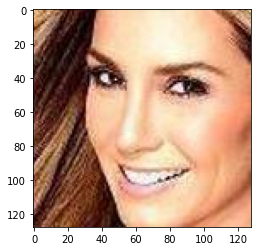

In [10]:
# test 
plt.imshow(face[0]*0.5+0.5)
print(au[0])

In [11]:
au_rand[0]

array([ 0.15064383,  0.21493763,  0.27330408,  0.04231337,  0.3172397 ,
        0.20259143, -0.05236365,  0.1506114 ,  0.3745935 ,  0.1677985 ,
       -0.19926037, -0.13099095,  0.1524912 , -0.26355585, -0.2282852 ,
       -0.23224568,  0.12064917], dtype=float32)

In [18]:
lambda_D_image = 1
lambda_D_au = 4000
lambda_D_gp = 10
lambda_cyc = 10
lambda_mask = 0.1
lambda_mask_smooth = 1e-5
BATCH_SIZE = 25

In [25]:

def WGAN_GP_train_g_step(real_image, real_au ,desired_au, lr):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    G_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        
        fake_img, fake_mask = generator([real_img, desired_au])
        fake_img_masked = fake_mask * real_img + (1 - fake_mask) * fake_img
        
        # G(G(Ic1, c2)*M, c1) * M
        cyc_img, cyc_mask = generator([fake_img_masked, real_au])
        cyc_img_masked = cyc_mask * fake_img_masked + (1 - cyc_mask) * cyc_img

        # D(real_I)
        pred_real_img, pred_real_au = discriminator([real_img])
        # D(fake_I)
        pred_fake_img_masked, pred_fake_au = discriminator([fake_img_masked])

        loss_g_fake_img_masked = -tf.reduce_mean(pred_fake_img_masked) * lambda_D_img
        loss_g_fake_au = l2_loss(desired_au, pred_fake_au) * lambda_D_au
        loss_g_cyc = l1_loss(real_img, cyc_img_masked) * lambda_cyc

        loss_g_mask_fake = tf.reduce_mean(fake_mask) * lambda_mask + smooth_loss(fake_mask) * lambda_mask_smooth
        loss_g_mask_cyc = tf.reduce_mean(cyc_mask) * lambda_mask + smooth_loss(cyc_mask) * lambda_mask_smooth

        loss_g = loss_g_fake_img_masked+loss_g_fake_au+loss_g_cyc+loss_g_mask_fake+loss_g_mask_cyc
        
        
        
        
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(loss_g,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    
    return loss_g

In [26]:

def WGAN_GP_train_d_step(real_image, real_au ,desired_au, lr, BATCH_SIZE):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    D_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            
            fake_image, fake_mask = generator([real_image, desired_au])
            fake_image_masked = fake_mask * real_image + (1 - fake_mask) * fake_image # interpolates
            
            differences = fake_image_masked - real_image
            interpolates = real_image + tf.multiply(alpha, differences)
            fake_mixed_pred = discriminator([interpolates])
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2)
        
        
        pred_real_image, pred_real_au = discriminator([real_image])
        pred_fake_image_masked, pred_fake_au = discriminator([fake_image_masked])
        
        loss_d_image = -tf.reduce_mean(pred_real_image) * lambda_D_image + tf.reduce_mean(pred_fake_image_masked) * lambda_D_image
        loss_d_au = l2_loss(real_au, pred_real_au) * lambda_D_au
        
        loss_d = loss_d_image + loss_d_au + lambda_D_gp * gradient_penalty
        
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(loss_d,
                                            discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    
    return loss_d
    

In [27]:
discriminator.output

[<KerasTensor: shape=(None, 2, 2, 1) dtype=float32 (created by layer 'conv2d_48')>,
 <KerasTensor: shape=(None, 17) dtype=float32 (created by layer 'tf.compat.v1.squeeze_1')>]

In [15]:
# 兩張照片表情互換
def generate_and_save_images(generator, discriminator,image_1, image_2, figure_size=(12,6), subplot=(2,4), save=True, is_flatten=False):
    '''
        Generate images and plot it.
    '''
    real_image_1 = np.expand_dims(image_1,0)
    real_image_2 = np.expand_dims(image_2,0)
    
    _, image_1_au = discriminator([real_image_1])
    _, image_2_au = discriminator([real_image_2])
    
    
    fake_image_1, fake_mask_1 = generator([real_image_1, image_2_au])
    fake_image_masked_1 = fake_mask_1 * real_image_1 + (1 - fake_mask_1) * fake_image_1
    
    fake_image_2, fake_mask_2 = generator([real_image_2, image_1_au])
    fake_image_masked_2 = fake_mask_2 * real_image_2 + (1 - fake_mask_2) * fake_image_2
    
    
    
    
    fig = plt.figure(figsize=figure_size)
    
    plt.subplot(2,4,1)
    plt.imshow(np.squeeze(real_image_1)*0.5+0.5)
    plt.title('Original_img')
    
    plt.subplot(2,4,2)
    plt.imshow(np.squeeze(fake_mask_1), cmap = 'gray')
    plt.title('fake_mask')
    
    
    plt.subplot(2,4,3)
    plt.imshow(np.squeeze(fake_image_1)*0.5+0.5)
    plt.title('fake_img')
    
    
    plt.subplot(2,4,4)
    plt.imshow(np.squeeze(fake_image_masked_1)*0.5+0.5)
    plt.title('predictions')
    ###
    
    plt.subplot(2,4,5)
    plt.imshow(np.squeeze(real_image_2)*0.5+0.5)
    plt.title('Original_img')
    
    plt.subplot(2,4,6)
    plt.imshow(np.squeeze(fake_mask_2), cmap = 'gray')
    plt.title('fake_mask')
    
    
    plt.subplot(2,4,7)
    plt.imshow(np.squeeze(fake_image_2)*0.5+0.5)
    plt.title('fake_img')
    
    
    plt.subplot(2,4,8)
    plt.imshow(np.squeeze(fake_image_masked_2)*0.5+0.5)
    plt.title('predictions')
    
 
    plt.show()

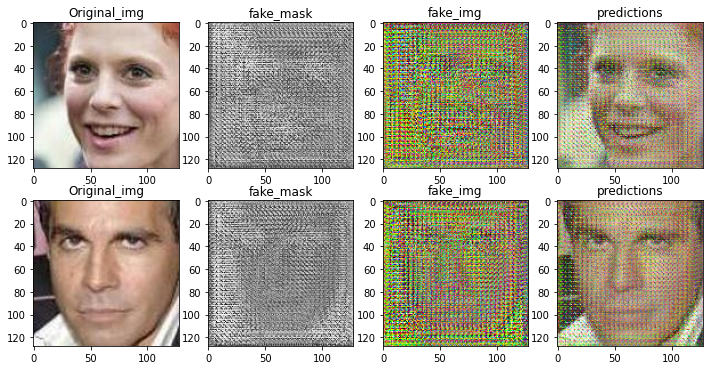

In [28]:
image_1 = face[1]
image_2 = face[5]

# We will reuse this seed overtime

generate_and_save_images(generator, discriminator,image_1, image_2, figure_size=(12,6), subplot=(2,4), save=True, is_flatten=False)

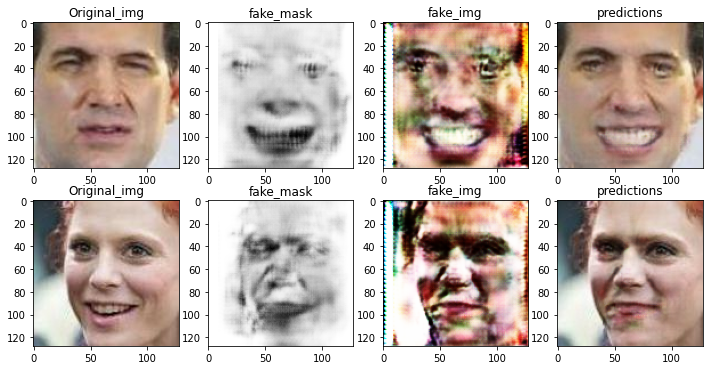

KeyboardInterrupt: 

In [54]:
image_1 = face[12]
image_2 = face[1]
EPOCHS = 30
print('--- start training ---')
for e in range(25, EPOCHS +1):
    start_time = time.time()
    if e <= 21:
        lr_now = 1e-4
    else:
        lr_now = 1e-5*(EPOCHS+1-e)
    
    for i in range(len(face) // BATCH_SIZE):
        real_img = face[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        real_au = au[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        desired_au = au_rand[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        d_loss = WGAN_GP_train_d_step(real_img, real_au, desired_au, lr_now, BATCH_SIZE)
        
        if (i+1)%5 == 0:
            g_loss = WGAN_GP_train_g_step(real_img, real_au, desired_au, lr_now)
            clear_output(wait=True)
            generate_and_save_images(generator, discriminator,image_1, image_2, figure_size=(12,6), subplot=(2,4), save=True, is_flatten=False)
    print('(spend time: %.2fmin) loss_g: %.4f  loss_d: %.4f \n' %((time.time()-start_time)/60, g_loss, d_loss))



In [55]:
e

25

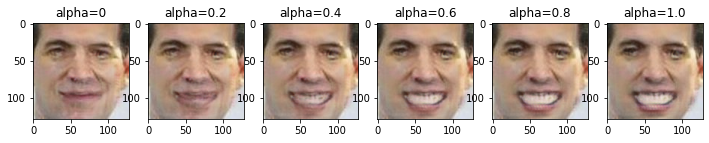

In [81]:
idx = -3

image_1 = face[12]
image_2 = face[1]

real_image_1 = np.expand_dims(image_1,0)
real_image_2 = np.expand_dims(image_2,0)

_, image_1_au = discriminator([real_image_1])
_, image_2_au = discriminator([real_image_2])

new_au = image_2_au.numpy() # 1,17

lst = [0,0.2,0.4,0.6,0.8,1.0]

plt.figure(figsize = (12,6))

for i in range(len(lst)):
    new_au_ = new_au.copy()
    new_au[:,idx] = lst[i]
    fake_image_1, fake_mask_1 = generator([real_image_1, new_au])
    fake_image_masked_1 = fake_mask_1 * real_image_1 + (1 - fake_mask_1) * fake_image_1

    
    plt.subplot(1,6,i+1)
    plt.imshow(np.squeeze(fake_image_masked_1*0.5+0.5))
    plt.title(f'alpha={lst[i]}')
    
    








    
    
    